In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.stats
#import seaborn as sns
#sns.set(style="whitegrid")
import time
import seaborn as sns; sns.set()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy
import random

# Functions

In [362]:
def Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn):
    scale_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        scale_ext[r,:eff_date] = sigma_adjust1[r]*np.ones(int(eff_date))
        scale_ext[r,eff_date:] = d*sigma_adjust2[r]*np.ones(int(nn - eff_date))
    return scale_ext

In [363]:
def C_series(eff_dates,pr1,pr2,nn):
    C_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        C_ext[r,:eff_date] = pr1*np.ones(int(eff_date))
        C_ext[r,eff_date:] = pr2*np.ones(int(nn - eff_date))
    return C_ext

In [364]:
# function without shielding
def SEIR_Policy_on_off(init_vals, C_, Sigma_, p,f, params, d, eff_dates,sigma_adjust1,sigma_adjust2,threshold1,threshold2,relax,control_last,last_bf_stop,nn):
    ## input
    # nn is the number of days
    #S_0,E_0,I_0,R_0: dimension: A*R
    # C is a matrix in dimension R*R with compotnent c_(r,r')
    # p is vector in dimension A with each column equals to p_a
    S_0, E_0, I_0, A_0, D_0,R_0 = init_vals
    
    N_A, N_K = S_0.shape[0], S_0.shape[1]
      
    S, E, I, A, D, R = [S_0], [E_0], [I_0], [A_0], [D_0],[R_0]
    
    # N: total number of people in each class: matrix dimension A*R
    N = S_0 + E_0 + I_0 + R_0 +D_0+ A_0
    S_i, E_i, I_i, A_i, D_i, R_i = S_0.copy(), E_0.copy(), I_0.copy(), A_0.copy(), D_0.copy(),R_0.copy()
    alpha, beta, gamma, kappa,pi1,pi2  = params
    Sigma = Sigma_
    C = C_
    
    ### time-dependent parameters
    scale_ts = Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn)
    C_ts = C_series(eff_dates,1.0,0.2,nn)
    
    total_contact = 0
    regional_real_cases = np.zeros((nn+1,N_A,N_K))
    regional_confirm_cases = np.zeros((nn+1,N_A,N_K))
    england_real_cases = np.zeros((nn+1,N_A))
    england_confirm_cases = np.zeros((nn+1,N_A))
    
    regional_real_cases[0,:,] = I_0
    england_real_cases[0] = np.sum(I_0)
    for region in range(N_K):
            for age in range(N_A):
                number = I_0[age,region]
                regional_confirm_cases[0,age,region] =  np.random.binomial(number, pi1, 1)[0] 
    england_confirm_cases[0,:] = np.sum(regional_confirm_cases[0,:,:],axis=1)
    
    # signal==0 means relax policy (not control)
    # signal > 0 means control
    signal = 1 
    signals = np.zeros(nn+1)
    signals[0] = 1
    consecutive_pointer = last_bf_stop
    
    mask_base = np.arange(16)
    mask = (mask_base < 4) | (mask_base > 11)
    for t in range(nn):
        day_contact = 0
        Lambda = np.zeros((N_A,N_K))
        if signal > 0:
            C_r = C_ts[:,t]*C_ + (1-C_ts[:,t])*np.identity(N_K)
            Lambda += np.dot(Sigma[:,mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha *(kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:])
            Lambda += np.dot(Sigma[:,~mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha * np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T))
            day_contact += (N * np.dot(np.reshape(np.sum(Sigma, axis=-1), (-1, 1)), np.reshape(scale_ts[:,t], (1, -1)))).flatten().sum()
            
            #for r in range(N_K):
            #    C_r = C_ts[r,t]*C_ + (1-C_ts[r,t])*np.identity(133)
            #    for a in range(N_A):
            #        for a_prime in [0,1,2,3,12,13,14,15]:
            #            Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
            #        for a_prime in [4,5,6,7,8,9,10,11]:
            #            Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
            #    
            #        day_contact +=  N[a,r] * scale_ts[r,t] * np.sum(Sigma[a,:])
        if signal ==0 :
            C_ts_tmp = relax
            C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(N_K)
            scale_ts_tmp = relax*sigma_adjust1 + (1-relax)*scale_ts[:,t] 
            Lambda += (alpha * np.dot(Sigma[:, mask], (kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:] * scale_ts_tmp.reshape((1, -1))))
            Lambda += (alpha * np.dot(Sigma[:,~mask], np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T) * scale_ts_tmp.reshape((1, -1))))
            day_contact +=  (N * np.dot(Sigma.sum(axis=-1).reshape((-1, 1)), scale_ts_tmp.reshape((1, -1)))).flatten().sum()
            
            
            #for r in range(N_K):
            #    C_ts_tmp = relax #np.min([1,relax*C_ts[r,t]])
            #    C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(133)
            #    scale_ts_tmp = relax*sigma_adjust1[r]+ (1-relax)*scale_ts[r,t]
            #    for a in range(N_A):
            #        for a_prime in [0,1,2,3,12,13,14,15]:
            #            Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
            #        for a_prime in [4,5,6,7,8,9,10,11]:
            #            Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                
            #        day_contact +=  N[a,r] *scale_ts_tmp*np.sum(Sigma[a,:])
        #if signal == -1 : 
        #    C_r =C_
        #    scale_ts_tmp = sigma_adjust1 
        #    Lambda += (alpha * np.dot(Sigma[:, mask], (kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:] * scale_ts_tmp.reshape((1, -1))))
        #    Lambda += (alpha * np.dot(Sigma[:,~mask], np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T) * scale_ts_tmp.reshape((1, -1))))
        #    day_contact +=  (N * np.dot(Sigma.sum(axis=-1).reshape((-1, 1)), scale_ts_tmp.reshape((1, -1)))).flatten().sum()
            
            
            #for r in range(N_K):
            #    C_r = C_
            #    for a in range(N_A):
            #        for a_prime in [0,1,2,3,12,13,14,15]:
            #            Lambda[a,r] += sigma_adjust1[r] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
            #        for a_prime in [4,5,6,7,8,9,10,11]:
            #            Lambda[a,r] += sigma_adjust1[r]* alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
            #    
            #        day_contact +=  N[a,r] *sigma_adjust1[r]*np.sum(Sigma[a,:])
        
        total_contact += day_contact        
        dI_i = np.zeros((N_A,N_K))
        dA_i = np.zeros((N_A,N_K))
        for a in range(N_A):
            dI_i[a,:] += p[a]*beta*E_i[a,:]
            dA_i[a,:] += (1-p[a])*beta*E_i[a,:]
        
        compartment_prob = np.array([(S_i*Lambda), dI_i, dA_i ,(gamma*f*I_i),(gamma*(1-f)*I_i),(gamma*A_i)]).reshape(6*N_A*N_K)

        compartment_prob = np.asarray(compartment_prob).astype(np.float64)
        ratio = np.sum(compartment_prob)
        if ratio > 0:
            compartment_prob /= np.sum(compartment_prob)
        else:
            total_contact += (nn-t)*day_contact   
            return S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases,  total_contact

        number_event = np.random.poisson(ratio,1)[0]
    
        ind = np.random.multinomial(number_event, compartment_prob, size=1)
        
        ind = ind.reshape(6,N_A,N_K)

        

        S_i += -ind[0,:,:]
        E_i += ind[0,:,:]-ind[1,:,:]-ind[2,:,:]
        I_i += ind[1,:,:]-ind[3,:,:]-ind[4,:,:]
        A_i += ind[2,:,:]-ind[5,:,:]
        D_i += ind[3,:,:]
        R_i += ind[4,:,:]+ind[5,:,:]
        
        S_i = (np.abs(S_i)+S_i)/2
        E_i = (np.abs(E_i)+E_i)/2
        A_i = (np.abs(A_i)+A_i)/2
        D_i = (np.abs(D_i)+D_i)/2
        I_i = (np.abs(I_i)+I_i)/2
        R_i = (np.abs(R_i)+R_i)/2
        
        regional_real_cases[t+1,:,:] = ind[1,:,:]
        england_real_cases[t+1,:] = np.sum(ind[1,:,:],axis=1)
        
        if t <= 120:
            pi_ = pi1
        else:
            pi_ = pi2
        
        for region in range(N_K):
            for age in range(N_A):
                number = ind[1,age,region]
                regional_confirm_cases[t+1,age,region] =  np.random.binomial(number, pi_, 1)[0] 
        
        today_confirm = np.sum(regional_confirm_cases[t+1,:,:],axis=1)
        england_confirm_cases[t+1,:] = today_confirm
        # threshold2 < threshold1
        if (np.sum(today_confirm)<threshold2) & (signal >=control_last) & (t> 120):
            signal = 0
        elif (np.sum(today_confirm)<threshold1) & (signal ==0) & (consecutive_pointer == 0):
            signal = -1
        elif (np.sum(today_confirm)<threshold1) & (signal ==-1):
            signal = -1
        elif (np.sum(today_confirm)<threshold1) & (signal ==0) & (consecutive_pointer > 0):
            signal = 0
            consecutive_pointer -=1
        else:
            signal = np.max([0,signal]) +1
            consecutive_pointer = last_bf_stop
        signals[t+1] = signal
        
        S.append(S_i.copy())
        E.append(E_i.copy())
        I.append(I_i.copy())
        A.append(A_i.copy())
        D.append(D_i.copy())
        R.append(R_i.copy())
         
    return S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact

# Import Data

In [365]:
N_A= 16
N_K = 133
initial_day = 15

In [366]:
# social contact among age group
contact = pd.read_csv('../../../data/contact_matrix_16_groups.csv')
social_m = np.array(contact[['matrix..0.5.', 'matrix..5.10.', 'matrix..10.15.', 'matrix..15.20.',
       'matrix..20.25.', 'matrix..25.30.', 'matrix..30.35.', 'matrix..35.40.',
       'matrix..40.45.', 'matrix..45.50.', 'matrix..50.55.', 'matrix..55.60.',
       'matrix..60.65.', 'matrix..65.70.', 'matrix..70.75.', 'matrix.75.']]).reshape(16,16)

Sigma = social_m

In [367]:
#contact mtrix
transport = pd.read_csv('../../../data/CommuteMatrix-NUTS3.csv')
transport_mat = np.array(transport)[:,1:].astype(float)
C = transport_mat

In [368]:
covid_data = pd.read_csv('../../../data/UK-COVID-data.csv')
covid_data_new = pd.DataFrame(columns = covid_data.columns)
region_order = list(transport['Unnamed: 0'])

In [369]:
for i in range(133):
    region = region_order[i]
    covid_data_new.loc[i] = covid_data[covid_data['id']==region].values[0]
    #covid_data_new2.loc[i] = covid_data2[covid_data2['id']==region].values[0]

In [370]:
## Sanity check
print('does all tables have the same region order:')
covid_order = list(covid_data_new['id'])
#covid_order2 = list(covid_data_new2['id'])

region_order = list(transport['Unnamed: 0'])


print(region_order==covid_order)
#print(population_order==covid_order2)

does all tables have the same region order:
True


In [371]:
## Population data validation 
population = pd.read_csv('../../../data/UK-COVID-data-with_ALL_age_groups.csv')
population = population[['id','Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]

In [372]:
population_new = pd.DataFrame(columns = population.columns)


In [373]:
for i in range(133):
    region = region_order[i]
    population_new.loc[i] = population[population['id']==region].values[0]

In [374]:
N_mat2 = np.array(population_new[['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]).T

N_mat = np.zeros((16,133))

N_mat[:15,:] = N_mat2[:15,:]

N_mat[-1,:] = np.sum(N_mat2[15:,],axis=0)
np.sum(N_mat)

56171302.0

In [375]:
## Population density
population_density = np.array(covid_data_new['population_density'])

In [431]:
d_table =  pd.read_csv('../../../data/d1d2_effdates_initialization_final_lowratio_133regions_16agegroups.csv')

initial_covid = np.array(d_table['initialization'])

In [377]:
d_table 

,region,d_adjust1,d_adjust2,adjust_dates,initialization
0,UKC11,1.045941,1.466334,25.0,5.000000
1,UKC12,1.804483,1.018565,23.0,2.000000
2,UKC13,1.259746,1.202675,27.0,2.000000
3,UKC22,1.049231,0.959281,25.0,21.000000
4,UKD12,1.154643,0.940007,22.0,17.055149
...,...,...,...,...,...
128,UKJ28,0.849863,0.777999,23.0,8.458674
129,UKI75,1.085533,0.845362,18.0,36.000000
130,UKD44,1.317403,1.045672,24.0,3.587218
131,UKJ35,0.877225,0.937636,23.0,28.010320


In [378]:
sigma_adjust1 = np.array(d_table['d_adjust1'])
sigma_adjust2 = np.array(d_table['d_adjust2'])
simulation_eff_dates= np.array(d_table['adjust_dates'])

In [379]:
real_cum_cases = np.sum(np.array(covid_data_new.iloc[0:13,(19+initial_day):133]).astype(float),axis = 0)

In [380]:
real_cum_cases_ind = np.cumsum(np.ones(len(real_cum_cases)))+initial_day

In [381]:
death_data = pd.read_csv('../../../data/coronavirus-deaths_0521.csv')

cum_death_number = np.array(death_data[death_data['Area name']=='England'][::-1].iloc[9:]['Cumulative deaths'])

cum_death_number_ind = np.cumsum(np.ones(len(cum_death_number)))+initial_day

# Initialization


In [382]:
alpha = 0.055 #+ np.random.normal(0, 0.01, 1)[0]
beta = 0.2 #+ np.random.normal(0, 0.05, 1)[0]
gamma = 0.1 #+ np.random.normal(0, 0.02, 1)[0]
kappa = 0.5 # + np.random.normal(0, 0.05, 1)[0]
f0 = 0.002 
f1 = 0.002
f2 = 0.01
f3 = 0.01
f4 = 0.05
f5 = 0.05
f6 = 0.1
f7 = 0.1
f8 =  0.2
f9 = 0.2
f10 = 0.6
f11 = 0.6
f12 = 2.0
f13 = 2.0
f14 = 4.0
f15 = 7.5 

p0 = 0.075 
p1 =  0.075
p2 = 0.05
p3 = 0.05
p4 = 0.15
p5 = 0.15
p6 = 0.21
p7 = 0.21
p8 =  0.23 
p9 = 0.23 
p10 = 0.28
p11 = 0.28
p12 =  0.41
p13 =  0.41
p14 =  0.375
p15 = 0.375
p = [p0,p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
pi1 = 4.5/100
pi2 = 4.5/100
# 0.005,0.25,2,6
f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi1,pi2

In [383]:
scale = 0.12

In [384]:
np.sum(initial_covid)

2652.096014648935

In [385]:
## initial population
init_sick = np.zeros((N_A,N_K))
init_sick_scale = np.zeros((N_A,N_K))
for a in [4,5,6,7,8,9,10,11]:
    init_sick[a,:] = initial_covid*(N_mat[a,:])/np.sum(N_mat[4:12,:],axis=0)

for a in [4,5,6,7,8,9,10,11]:
    init_sick_scale[a,:] = init_sick[a,:]/(p[a]*pi1)
#init_sick[1,44] = 5
#init_sick[1,64] = 5
init_vals = N_mat-(init_sick_scale).astype(int),(init_sick_scale).astype(int), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K))

In [386]:
sns.set(font_scale=1.3)

In [387]:
lag = 10

In [388]:
N_A

16

# Experiments

In [468]:
threshold1 =  40 * 56
threshold2 =  0.4 * threshold1
relax = 0.5
control_last = 7
nn = 500
end = nn+1
stop_bf_last = 2000
np.random.seed(2)
# 30: 4 controls
# 2: 3 controls
S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,threshold1,threshold2,relax,control_last,stop_bf_last,nn)

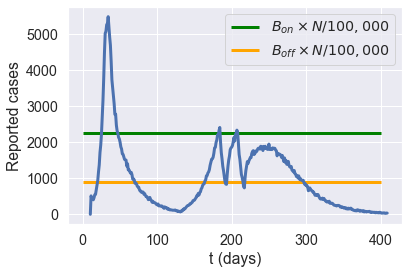

In [469]:
#plt.fill_between(xx[:400],b1,b2,alpha=0.5)
plt.plot(xx[:400],np.sum(england_confirm_cases,axis=1)[:400],linewidth=3)
plt.hlines(threshold1, 0,400,color='green',label=r'$ B_{on}\times N/100,000$',linewidth=3)
plt.hlines(threshold2, 0,400,color='orange',label=r'$ B_{off}\times N/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/centralised_reported_england_3path.png",bbox_inches="tight")

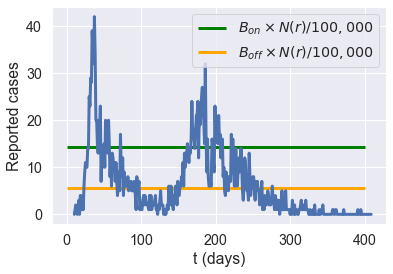

In [470]:
plt.plot(xx[:400],leicester_reported[path,:],linewidth=3)
plt.hlines(threshold1*pop_ratio, 0,400,color='green',label=r'$B_{on}\times N(r)/100,000$',linewidth=3)
plt.hlines(threshold2*pop_ratio, 0,400,color='orange',label=r'$B_{off}\times N(r)/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/centralised_reported_leicester_3path.png",bbox_inches="tight")

In [467]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/different_agegroups/16age_groups


In [415]:
I = np.array(I)

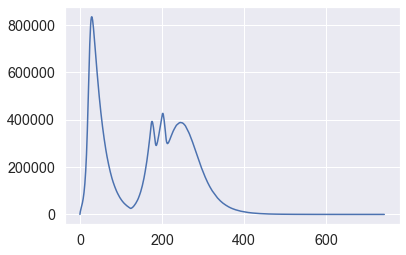

In [416]:
plt.plot(np.sum(I,axis=(1,2)))

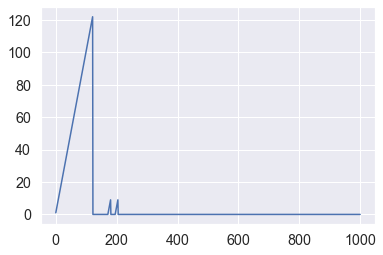

In [392]:
plt.plot(signals)

In [393]:
signals[120:240]

array([121., 122.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,
         4.,   5.,   6.,   7.,   8.,   9.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [394]:
np.sum(np.array(D)[-1,:,:])

132242.0

In [395]:
benchmark_total_contact2 = 0
for r in range(133):
    for a in range(4):
        benchmark_total_contact2 += N_mat[a,r]*sigma_adjust1[r]*nn*np.sum(Sigma[a,:])

In [396]:
benchmark_total_contact = 0
for r in range(133):
    for a in range(16):
        benchmark_total_contact += N_mat[a,r]*sigma_adjust1[r]*nn*np.sum(Sigma[a,:])

In [397]:
benchmark_total_contact - benchmark_total_contact2

426157736707.4202

In [398]:
xx = np.cumsum(np.ones(nn+1))-1+lag

In [399]:
paths = 10
D_ext = np.zeros((paths,nn+1,16,133))
I_ext = np.zeros((paths,nn+1,16,133))
A_ext = np.zeros((paths,nn+1,16,133))
R_ext = np.zeros((paths,nn+1,16,133))
costs = np.zeros(paths)
england_reported = np.zeros((paths,400))
leicester_reported = np.zeros((paths,400))
for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,threshold1,threshold2,relax,control_last,stop_bf_last,nn)
    england_reported[path,:] = np.sum(england_confirm_cases,axis=1)[:400]
    leicester_reported[path,:] = np.sum(regional_confirm_cases[:,:,37],axis=1)[:400]
    lenss = np.array(D).shape[0]
    D_ext[path,:lenss,:,:] = np.array(D)
    D_ext[path,lenss:,:,:] = np.array(D)[-1,:,:]
    R_ext[path,:lenss,:,:] = np.array(R)
    R_ext[path,lenss:,:,:] = np.array(R)[-1,:,:]
    I_ext[path,:lenss,:,:] = np.array(I)
    A_ext[path,:lenss,:,:] = np.array(A)
    costs[path] = benchmark_total_contact - total_contact

0
1
2
3
4
5
6
7
8
9


In [400]:
D_ext.shape

(10, 1001, 16, 133)

In [401]:
np.sum(np.mean(D_ext,axis=0),axis=1)[-1,:]

array([ 702.7,  893.2,  285.4, 2128.6,  844.8,  567.5, 1114.1, 1258.4,
       1262. , 1427.8,  351.1, 1162.9,  942.9,  712.9,  547.9,  959.9,
        911.8, 1264.2, 1100.7,  979.9,  970.4,  479.4,  847.6,  938.5,
        413. , 1926. , 2297.9, 1384.9, 1087.4, 1547. , 1642. ,  641.6,
        808.5, 1392.3,  425.3, 1224.2,  934. ,  616.8, 1990.6,  934.9,
        917.9, 2152.8,  509.5, 1805.5, 1520.2,  924.1,  583.6, 2272.9,
       2142.4,  759.8,  952.6,  750. ,  612.1,  530.1,  349.9, 1542.1,
       2054.1,  867.1,  882.2,  880.1,  399.7, 2293. ,  382.8,  502. ,
       1530.1,  912.7, 1011.8, 1128.5,  356.9,  306. ,  479.1,  471.9,
        733.9,  268. ,  655.2,  856. ,  467.6, 1080.4, 1059.4, 1183.1,
        713.8,  917.7, 1152.6,  631.5,  703.1, 1237. , 1402.9,  537. ,
        997.3, 1359.1,  508.5, 1997.5, 2108. , 1204.5, 1663.9,  438.1,
        502.1,  368.9, 1641.9,  802.6,  564.5,  879.4,  794.6,  953.2,
        830.3, 1573.8, 1708.5,  455.3, 1290.5,  906. , 1606.1, 1150.3,
      

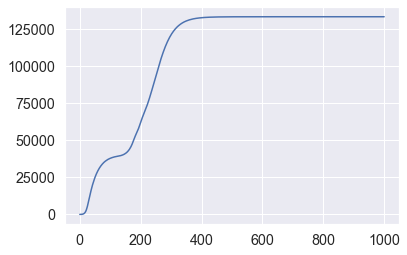

In [402]:
plt.plot(np.mean(np.sum(D_ext,axis=(2,3)),axis=0))

In [403]:
np.sum(np.mean(I_ext,axis=0),axis=(1,2))[155-lag]

80286.2

In [404]:
np.max(np.sum(np.mean(I_ext,axis=0),axis=(1,2))[100:])

423230.80000000005

In [405]:
np.sum(np.mean(A_ext,axis=0),axis=(1,2))[155-lag]

321195.3

In [406]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[155-lag]

40538.299999999996

In [407]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

133469.9

In [408]:
np.max(np.sum(np.mean(A_ext,axis=0),axis=(1,2))[100:])

1492273.7999999998

In [409]:
england_reported.shape

(10, 400)

In [410]:
np.mean(costs)

295669710420.4149

In [299]:
b1 = np.mean(england_reported,axis=0)+np.std(england_reported,axis=0)
b2 = np.mean(england_reported,axis=0)-np.std(england_reported,axis=0)


In [300]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/different_agegroups/16age_groups


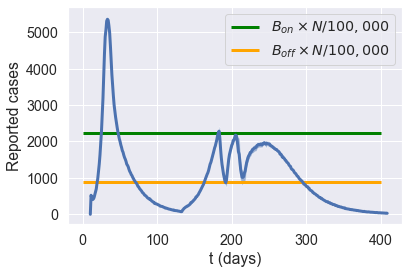

In [301]:
plt.fill_between(xx[:400],b1,b2,alpha=0.5)
plt.plot(xx[:400],np.mean(england_reported,axis=0),linewidth=3)
plt.hlines(threshold1, 0,400,color='green',label=r'$ B_{on}\times N/100,000$',linewidth=3)
plt.hlines(threshold2, 0,400,color='orange',label=r'$B_{off}\times N/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/centralised_reported_england_16agegroups.png",bbox_inches="tight")

In [302]:
england_reported.shape

(10, 400)

In [303]:
path=3

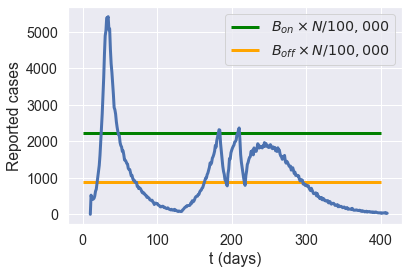

In [304]:
#plt.fill_between(xx[:400],b1,b2,alpha=0.5)
plt.plot(xx[:400],england_reported[path,:],linewidth=3)
plt.hlines(threshold1, 0,400,color='green',label=r'$ B_{on}\times N/100,000$',linewidth=3)
plt.hlines(threshold2, 0,400,color='orange',label=r'$ B_{off}\times N/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/centralised_reported_england_1path.png",bbox_inches="tight")

# Region 37

In [305]:
region_order[37]

'UKF21'

In [306]:
regional_real_cases.shape

(1001, 16, 133)

In [307]:
N_mat.shape

(16, 133)

In [308]:
pop_ratio = np.sum(N_mat[:,37])/np.sum(N_mat)

In [309]:
np.sum(N_mat[:,37])/100000*4

14.29576

In [310]:
threshold1*pop_ratio

14.252163141954588

In [311]:
threshold2*pop_ratio

5.700865256781835

In [312]:
a1 = np.mean(leicester_reported,axis=0)+np.std(leicester_reported,axis=0)
a2 = np.mean(leicester_reported,axis=0)-np.std(leicester_reported,axis=0)

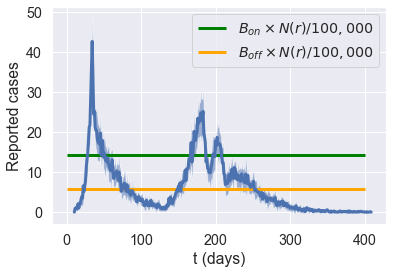

In [313]:
plt.fill_between(xx[:400],a1,a2,alpha=0.5)
plt.plot(xx[:400],np.mean(leicester_reported,axis=0),linewidth=3)
plt.hlines(threshold1*pop_ratio, 0,400,color='green',label=r'$B_{on}\times N(r)/100,000$',linewidth=3)
plt.hlines(threshold2*pop_ratio, 0,400,color='orange',label=r'$B_{off}\times N(r)/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/centralised_reported_leicester_16agegroups.png",bbox_inches="tight")

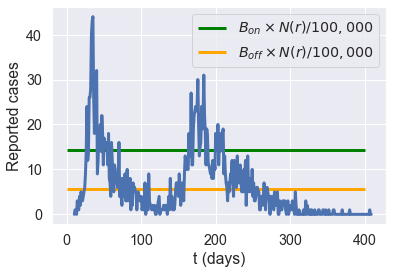

In [314]:
plt.plot(xx[:400],leicester_reported[path,:],linewidth=3)
plt.hlines(threshold1*pop_ratio, 0,400,color='green',label=r'$B_{on}\times N(r)/100,000$',linewidth=3)
plt.hlines(threshold2*pop_ratio, 0,400,color='orange',label=r'$B_{off}\times N(r)/100,000$',linewidth=3)
plt.ylabel('Reported cases')
plt.xlabel('t (days)')
plt.legend()
plt.savefig("results/centralised_reported_leicester_1path.png",bbox_inches="tight")

## Export for comparison

In [315]:
I_mean = np.mean(np.sum(I_ext,axis=(2,3)),axis=0)[:500]
I_std = np.std(np.sum(I_ext,axis=(2,3)),axis=0)[:500]

D_mean = np.mean(np.sum(D_ext,axis=(2,3)),axis=0)[:500]
D_std = np.std(np.sum(D_ext,axis=(2,3)),axis=0)[:500]

output = pd.DataFrame(columns = ["I_mean","I_std","D_mean","D_std"])
#plt.hlines(threshold1, 0,400,color='green',label=r'$ R_{on}\times N/100,000$',linewidth=3)
#plt.hlines(threshold2, 0,400,color='orange',label=r'$ R_{off}\times N/100,000$',linewidth=3)
output['I_mean'] = I_mean
output['I_std'] = I_std
output['D_mean'] = D_mean
output['D_std'] = D_std

output.to_csv('nation_adaptive_16agegroups.csv',index=False)

In [316]:
Re_Le_mean = np.mean(leicester_reported,axis=0)[:400]
Re_Le_std = np.std(leicester_reported,axis=0)[:400]

Re_En_mean = np.mean(england_reported,axis=0)[:400]
Re_En_std =np.std(england_reported,axis=0)[:400]

output = pd.DataFrame(columns = ["Re_Le_mean","Re_Le_std","Re_En_mean","Re_En_std"])
#plt.hlines(threshold1, 0,400,color='green',label=r'$ R_{on}\times N/100,000$',linewidth=3)
#plt.hlines(threshold2, 0,400,color='orange',label=r'$ R_{off}\times N/100,000$',linewidth=3)
output['Re_Le_mean'] = Re_Le_mean 
output['Re_Le_std'] = Re_Le_std
output['Re_En_mean'] = Re_En_mean
output['Re_En_std'] = Re_En_std

output.to_csv('nation_adaptive_16agegroups_reported.csv',index=False)

In [317]:
np.sum(np.mean(R_ext,axis=0),axis=(1,2))[-1]+np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

43303831.300000004

In [318]:
np.sum(np.mean(D_ext,axis=0),axis=(1,2))[-1]

133184.70000000004

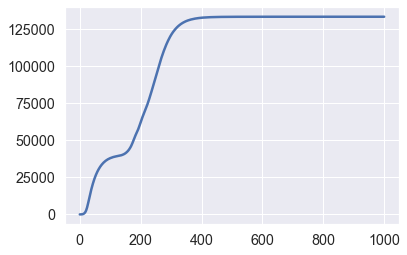

In [319]:
plt.plot(np.sum(np.mean(D_ext,axis=0),axis=(1,2)),linewidth=2.5)


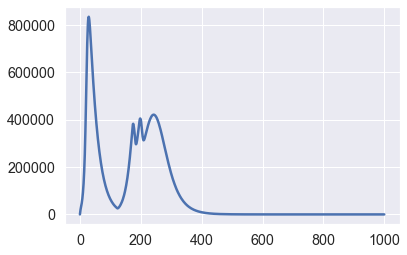

In [320]:
plt.plot(np.sum(np.mean(I_ext,axis=0),axis=(1,2)),linewidth=2.5)


In [321]:
print(region_order[69],region_order[89],region_order[48])

UKI32 UKJ14 UKG31


In [322]:
D_ext_region_69 = D_ext[:,:,:,69]
D_ext_region_89 = D_ext[:,:,:,89]
D_ext_region_48 =  D_ext[:,:,:,48]


D_ext_region_80 = D_ext[:,:,:,80]
I_ext_region_80 = I_ext[:,:,:,80]

D_ext_region_20 = D_ext[:,:,:,20]
I_ext_region_20 = I_ext[:,:,:,20]

D_ext_region_24 = D_ext[:,:,:,24]
I_ext_region_24 = I_ext[:,:,:,24]

D_ext_region_48 = D_ext[:,:,:,48]
I_ext_region_48 = I_ext[:,:,:,48]

D_ext_region_69 = D_ext[:,:,:,69]
I_ext_region_69 = I_ext[:,:,:,69]

D_ext_region_89 = D_ext[:,:,:,89]
I_ext_region_89 = I_ext[:,:,:,89]

D_ext_region_37 = D_ext[:,:,:,37]
I_ext_region_37 = I_ext[:,:,:,37]

data = {"region_24_I":np.sum(np.mean(I_ext_region_24,axis=0),axis=1) ,"region_24_D":np.sum(np.mean(D_ext_region_24,axis=0),axis=1),
        "region_48_I":np.sum(np.mean(I_ext_region_48,axis=0),axis=1) ,"region_48_D":np.sum(np.mean(D_ext_region_48,axis=0),axis=1),
        "region_69_I":np.sum(np.mean(I_ext_region_69,axis=0),axis=1) ,"region_69_D":np.sum(np.mean(D_ext_region_69,axis=0),axis=1),
        "region_89_I":np.sum(np.mean(I_ext_region_89,axis=0),axis=1) ,"region_89_D":np.sum(np.mean(D_ext_region_89,axis=0),axis=1),
        "region_37_I":np.sum(np.mean(I_ext_region_37,axis=0),axis=1) ,"region_37_D":np.sum(np.mean(D_ext_region_37,axis=0),axis=1),
        "england_I":np.sum(np.mean(I_ext,axis=0),axis=(1,2)),"england_D":np.sum(np.mean(D_ext,axis=0),axis=(1,2))}

In [323]:
data = pd.DataFrame(data)

data.to_csv('data/feedback_40_04R_050_07.csv',index=False)

In [324]:
total_death_rgs = np.zeros(133)

for i in range(133):
    total_death_rgs[i] = np.sum(np.mean(D_ext[:,:,:,i],axis=0),axis=1)[-1]

data_fatality = pd.DataFrame(columns=['region','death_countrywide'])

data_fatality['region'] = d_table['region']

data_fatality['death_countrywide'] = total_death_rgs

data_fatality.to_csv('data/death_visualziation.csv',index=False)

# Two extreme scenarios

In [325]:
relax =  0.5
th1 = 100  *56
th2 = th1 *0.4
last_day = 7
nn = 1000
stop_bf_last = 2000
paths = 5

D_ext4 = np.zeros((paths,nn+1,16,133))
I_ext4 = np.zeros((paths,nn+1,16,133))
costs4 = np.zeros(paths)

for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,th1,th2,relax,last_day,stop_bf_last,nn)
    lenss = np.array(D).shape[0]
    D_ext4[path,:lenss,:,:] = np.array(D)
    D_ext4[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_ext4[path,:lenss,:,:] = np.array(I)
    costs4[path] = benchmark_total_contact - total_contact


0
1
2
3
4


In [326]:
relax =  0.5
th1 = 20  *56
th2 = th1 *0.4
last_day = 7
nn = 1000
stop_bf_last = 2000
paths = 5

D_ext5 = np.zeros((paths,nn+1,16,133))
I_ext5 = np.zeros((paths,nn+1,16,133))
costs5 = np.zeros(paths)

for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,th1,th2,relax,last_day,stop_bf_last,nn)
    lenss = np.array(D).shape[0]
    D_ext5[path,:lenss,:,:] = np.array(D)
    D_ext5[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_ext5[path,:lenss,:,:] = np.array(I)
    costs5[path] = benchmark_total_contact - total_contact


0
1
2
3
4


In [327]:
Trags_I4 = np.sum(I_ext4, axis=(2,3))
Deaths4 =  np.sum(D_ext4, axis=(2,3))

I_mean4 = np.mean(Trags_I4, axis=0)
I_std4 = np.std(Trags_I4, axis=0)

D_mean4 = np.mean(Deaths4, axis=0)
D_std4 = np.std(Deaths4, axis=0)

Trags_I5 = np.sum(I_ext5, axis=(2,3))
Deaths5 =  np.sum(D_ext5, axis=(2,3))

I_mean5 = np.mean(Trags_I5, axis=0)
I_std5 = np.std(Trags_I5, axis=0)

D_mean5 = np.mean(Deaths5, axis=0)
D_std5 = np.std(Deaths5, axis=0)

In [328]:
print(np.mean(costs4),np.mean(costs5))

290940205922.38495 307282987122.97516


In [329]:
lag = 10

In [330]:
xx = np.cumsum(np.ones(len(D_mean5)))-1+lag

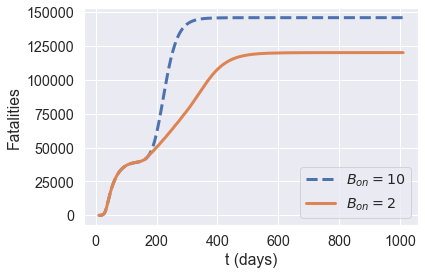

In [331]:
plt.plot(xx,D_mean4, linewidth = 3, label = "$B_{on}=10$",linestyle='--')
plt.plot(xx,D_mean5, linewidth = 3, label = "$B_{on}=2$")
plt.xlabel('t (days)')
plt.ylabel('Fatalities')
plt.legend()
plt.savefig('results/extreme_countrywide_feedback_comparison_Dt_lowratio.png',bbox_inches="tight")

In [332]:
(D_mean4[-1]-D_mean5[-1])/D_mean4[-1]

0.17669520864897476

In [333]:
D_mean5[-1]

120093.0

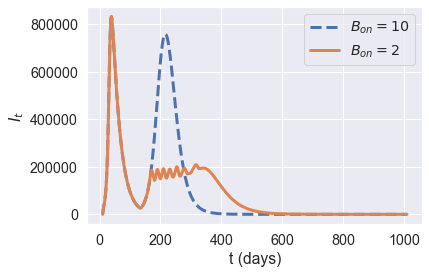

In [334]:
plt.plot(xx,I_mean4, linewidth = 3, label = "$B_{on}=10$",linestyle='--')
plt.plot(xx,I_mean5, linewidth = 3, label = "$B_{on}=2$")
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.legend()
plt.savefig('results/extreme_countrywide_feedback_comparison_It_lowratio.png',bbox_inches="tight")

In [335]:
region = 89

In [336]:
region_order[region]

'UKJ14'

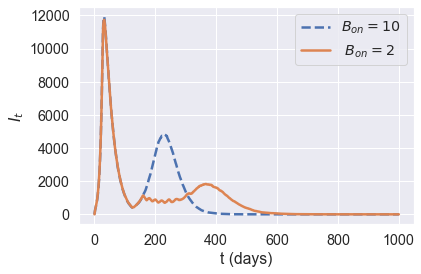

In [337]:
plt.plot(np.mean(np.sum(I_ext4,axis=2),axis=0)[:,region],linewidth=2.5, label = r"$B_{on}=10$ ",linestyle='--')
plt.plot(np.mean(np.sum(I_ext5,axis=2),axis=0)[:,region],linewidth=2.5, label = " $B_{on}=2$")
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.legend()
plt.savefig('results/extreme_countrywide_feedback_comparison_UKJ14_lowratio.png',bbox_inches="tight")

# Increasing reporting probability

In [338]:
pi1 = 4.5/100
pi2 = 4.5/100
# 0.005,0.25,2,6
#f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi1,pi2

In [339]:
relax =  0.5
th1 = 60  *56
th2 = th1 *0.4
last_day = 7
nn = 1000
stop_bf_last = 2000
paths = 5

D_ext7 = np.zeros((paths,nn+1,16,133))
I_ext7 = np.zeros((paths,nn+1,16,133))
costs7 = np.zeros(paths)
np.random.seed(5)
for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,th1,th2,relax,last_day,stop_bf_last,nn)
    lenss = np.array(D).shape[0]
    D_ext7[path,:lenss,:,:] = np.array(D)
    D_ext7[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_ext7[path,:lenss,:,:] = np.array(I)
    costs7[path] = benchmark_total_contact - total_contact



0
1
2
3
4


In [340]:
pi1 = 4.5/100
pi2 = 20/100
# 0.005,0.25,2,6
#f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi1,pi2

In [341]:
relax =  0.5
th1 = 60  *56
th2 = th1 *0.4
last_day = 7
nn = 1000
stop_bf_last = 2000
paths = 5

D_ext8 = np.zeros((paths,nn+1,16,133))
I_ext8 = np.zeros((paths,nn+1,16,133))
costs8 = np.zeros(paths)
np.random.seed(5)

for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,th1,th2,relax,last_day,stop_bf_last,nn)
    lenss = np.array(D).shape[0]
    D_ext8[path,:lenss,:,:] = np.array(D)
    D_ext8[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_ext8[path,:lenss,:,:] = np.array(I)
    costs8[path] = benchmark_total_contact - total_contact

0
1
2
3
4


In [342]:
pi1 = 4.5/100
pi2 = 50/100
# 0.005,0.25,2,6
#f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi1,pi2

In [343]:
relax =  0.5
th1 = 60  *56
th2 = th1 *0.4
last_day = 7
nn = 1000
stop_bf_last = 2000
paths = 5

D_ext9 = np.zeros((paths,nn+1,16,133))
I_ext9 = np.zeros((paths,nn+1,16,133))
costs9 = np.zeros(paths)
np.random.seed(5)

for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,th1,th2,relax,last_day,stop_bf_last,nn)
    lenss = np.array(D).shape[0]
    D_ext9[path,:lenss,:,:] = np.array(D)
    D_ext9[path,lenss:,:,:] = np.array(D)[-1,:,:]
    I_ext9[path,:lenss,:,:] = np.array(I)
    costs9[path] = benchmark_total_contact - total_contact

0
1
2
3
4


In [344]:
Trags_I7 = np.sum(I_ext7, axis=(2,3))
Deaths7 =  np.sum(D_ext7, axis=(2,3))

I_mean7 = np.mean(Trags_I7, axis=0)
I_std7 = np.std(Trags_I7, axis=0)

D_mean7 = np.mean(Deaths7, axis=0)
D_std7 = np.std(Deaths7, axis=0)

Trags_I8 = np.sum(I_ext8, axis=(2,3))
Deaths8 =  np.sum(D_ext8, axis=(2,3))

I_mean8 = np.mean(Trags_I8, axis=0)
I_std8 = np.std(Trags_I8, axis=0)

D_mean8 = np.mean(Deaths8, axis=0)
D_std8 = np.std(Deaths8, axis=0)


Trags_I9 = np.sum(I_ext9, axis=(2,3))
Deaths9 =  np.sum(D_ext9, axis=(2,3))

I_mean9 = np.mean(Trags_I9, axis=0)
I_std9 = np.std(Trags_I9, axis=0)

D_mean9 = np.mean(Deaths9, axis=0)
D_std9 = np.std(Deaths9, axis=0)

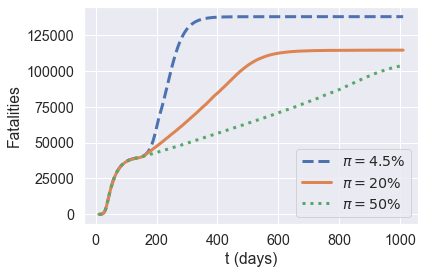

In [345]:
plt.plot(xx,D_mean7, linewidth = 3, label = r"$\pi=4.5\%$",linestyle='--')
plt.plot(xx,D_mean8, linewidth = 3, label = r"$\pi=20\%$")
plt.plot(xx,D_mean9, linewidth = 3, label = r"$\pi=50\%$",linestyle=':')

plt.xlabel('t (days)')
plt.ylabel('Fatalities')
plt.legend()
plt.savefig('results/countrywide_feedback_testing_capacity_Dt_lowratio.png',bbox_inches="tight")

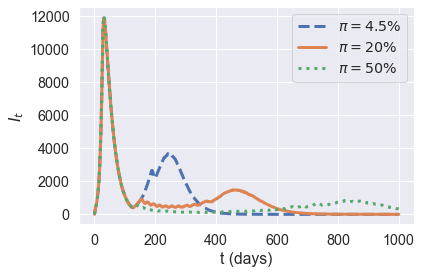

In [346]:
plt.plot(np.mean(np.sum(I_ext7,axis=2),axis=0)[:,region],linewidth=3, label = r"$\pi=4.5\%$",linestyle='--')
plt.plot(np.mean(np.sum(I_ext8,axis=2),axis=0)[:,region],linewidth=3, label = r"$\pi=20\%$")
plt.plot(np.mean(np.sum(I_ext9,axis=2),axis=0)[:,region],linewidth=3, label = r"$\pi=50\%$",linestyle=':')
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.legend()
plt.savefig('results/countrywide_feedback_testing_capacity_It_lowratio.png',bbox_inches="tight")

In [347]:
print(np.mean(costs7),np.mean(costs8),np.mean(costs9))

293102265121.4845 317174407958.8544 362793857059.84924


In [348]:
print(D_mean7[-1],D_mean8[-1],D_mean9[-1])

137616.4 114311.6 103701.8


In [241]:
sigma_adjust1.sort() 

In [349]:
d_table

,region,d_adjust1,d_adjust2,adjust_dates,initialization
0,UKC11,1.045941,1.466334,25.0,5.000000
1,UKC12,1.804483,1.018565,23.0,2.000000
2,UKC13,1.259746,1.202675,27.0,2.000000
3,UKC22,1.049231,0.959281,25.0,21.000000
4,UKD12,1.154643,0.940007,22.0,17.055149
...,...,...,...,...,...
128,UKJ28,0.849863,0.777999,23.0,8.458674
129,UKI75,1.085533,0.845362,18.0,36.000000
130,UKD44,1.317403,1.045672,24.0,3.587218
131,UKJ35,0.877225,0.937636,23.0,28.010320


In [350]:
d_table['region'][d_table['d_adjust1']>1.50]

1      UKC12
79     UKI53
81     UKI62
121    UKG32
122    UKC23
Name: region, dtype: object

In [351]:
d_table['region'][d_table['d_adjust1']>1.80]

1    UKC12
Name: region, dtype: object

# Region National Comparison 2

In [352]:
pi1 = 4.5/100
pi2 = 4.5/100
# 0.005,0.25,2,6
#f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi1,pi2

In [353]:
threshold1 =  60* 56
threshold2 =  0.4 * threshold1
relax = 0.5
control_last = 7
nn = 1000
end = nn+1
stop_bf_last = 2000


In [354]:
paths = 20
D_ext = np.zeros((paths,nn+1,16,133))
I_ext = np.zeros((paths,nn+1,16,133))
A_ext = np.zeros((paths,nn+1,16,133))
R_ext = np.zeros((paths,nn+1,16,133))
costs = np.zeros(paths)
england_reported = np.zeros((paths,400))
leicester_reported = np.zeros((paths,400))
for path in range(paths):
    print(path)
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_on_off(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,threshold1,threshold2,relax,control_last,stop_bf_last,nn)
    england_reported[path,:] = np.sum(england_confirm_cases,axis=1)[:400]
    leicester_reported[path,:] = np.sum(regional_confirm_cases[:,:,37],axis=1)[:400]
    lenss = np.array(D).shape[0]
    D_ext[path,:lenss,:,:] = np.array(D)
    D_ext[path,lenss:,:,:] = np.array(D)[-1,:,:]
    R_ext[path,:lenss,:,:] = np.array(R)
    R_ext[path,lenss:,:,:] = np.array(R)[-1,:,:]
    I_ext[path,:lenss,:,:] = np.array(I)
    A_ext[path,:lenss,:,:] = np.array(A)
    costs[path] = benchmark_total_contact - total_contact

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


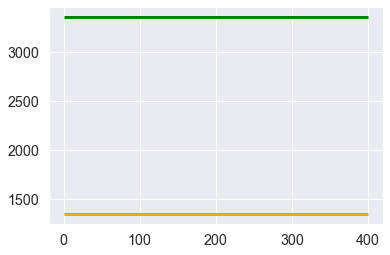

In [355]:
I_mean = np.mean(np.sum(I_ext,axis=(2,3)),axis=0)[:500]
I_std = np.std(np.sum(I_ext,axis=(2,3)),axis=0)[:500]

D_mean = np.mean(np.sum(D_ext,axis=(2,3)),axis=0)[:500]
D_std = np.std(np.sum(D_ext,axis=(2,3)),axis=0)[:500]

output = pd.DataFrame(columns = ["I_mean","I_std","D_mean","D_std"])
plt.hlines(threshold1, 0,400,color='green',label=r'$ R_{on}\times N/100,000$',linewidth=3)
plt.hlines(threshold2, 0,400,color='orange',label=r'$ R_{off}\times N/100,000$',linewidth=3)
output['I_mean'] = I_mean
output['I_std'] = I_std
output['D_mean'] = D_mean
output['D_std'] = D_std

output.to_csv('nation_adaptive_16agegroups_60_04R_040_07.csv',index=False)

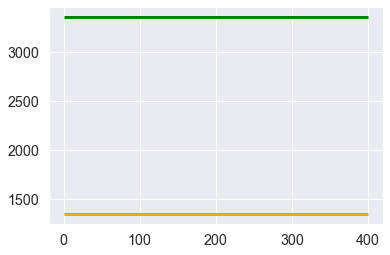

In [356]:
Re_Le_mean = np.mean(leicester_reported,axis=0)[:400]
Re_Le_std = np.std(leicester_reported,axis=0)[:400]

Re_En_mean = np.mean(england_reported,axis=0)[:400]
Re_En_std =np.std(england_reported,axis=0)[:400]

output = pd.DataFrame(columns = ["Re_Le_mean","Re_Le_std","Re_En_mean","Re_En_std"])
plt.hlines(threshold1, 0,400,color='green',label=r'$ R_{on}\times N/100,000$',linewidth=3)
plt.hlines(threshold2, 0,400,color='orange',label=r'$ R_{off}\times N/100,000$',linewidth=3)
output['Re_Le_mean'] = Re_Le_mean 
output['Re_Le_std'] = Re_Le_std
output['Re_En_mean'] = Re_En_mean
output['Re_En_std'] = Re_En_std

output.to_csv('nation_adaptive_16agegroups_reported_60_04R_040_07.csv',index=False)

In [357]:
D_ext_region_69 = D_ext[:,:,:,69]
D_ext_region_89 = D_ext[:,:,:,89]
D_ext_region_48 =  D_ext[:,:,:,48]


D_ext_region_80 = D_ext[:,:,:,80]
I_ext_region_80 = I_ext[:,:,:,80]

D_ext_region_20 = D_ext[:,:,:,20]
I_ext_region_20 = I_ext[:,:,:,20]

D_ext_region_24 = D_ext[:,:,:,24]
I_ext_region_24 = I_ext[:,:,:,24]

D_ext_region_48 = D_ext[:,:,:,48]
I_ext_region_48 = I_ext[:,:,:,48]

D_ext_region_69 = D_ext[:,:,:,69]
I_ext_region_69 = I_ext[:,:,:,69]

D_ext_region_89 = D_ext[:,:,:,89]
I_ext_region_89 = I_ext[:,:,:,89]

D_ext_region_37 = D_ext[:,:,:,37]
I_ext_region_37 = I_ext[:,:,:,37]

data = {"region_24_I":np.sum(np.mean(I_ext_region_24,axis=0),axis=1) ,"region_24_D":np.sum(np.mean(D_ext_region_24,axis=0),axis=1),
        "region_48_I":np.sum(np.mean(I_ext_region_48,axis=0),axis=1) ,"region_48_D":np.sum(np.mean(D_ext_region_48,axis=0),axis=1),
        "region_69_I":np.sum(np.mean(I_ext_region_69,axis=0),axis=1) ,"region_69_D":np.sum(np.mean(D_ext_region_69,axis=0),axis=1),
        "region_89_I":np.sum(np.mean(I_ext_region_89,axis=0),axis=1) ,"region_89_D":np.sum(np.mean(D_ext_region_89,axis=0),axis=1),
        "region_37_I":np.sum(np.mean(I_ext_region_37,axis=0),axis=1) ,"region_37_D":np.sum(np.mean(D_ext_region_37,axis=0),axis=1),
        "england_I":np.sum(np.mean(I_ext,axis=0),axis=(1,2)),"england_D":np.sum(np.mean(D_ext,axis=0),axis=(1,2))}

In [358]:
data = pd.DataFrame(data)

data.to_csv('data/feedback_60_04R_040_07.csv',index=False)

In [360]:
total_death_rgs = np.zeros(133)

for i in range(133):
    total_death_rgs[i] = np.sum(np.mean(D_ext[:,:,:,i],axis=0),axis=1)[-1]

data_fatality = pd.DataFrame(columns=['region','death_countrywide'])

data_fatality['region'] = d_table['region']

data_fatality['death_countrywide'] = total_death_rgs

data_fatality.to_csv('data/death_visualziation_60_04R_040_07.csv',index=False)